<a href="https://colab.research.google.com/github/cksghcksh/2022_cau_oss_hackathon/blob/main/hackathon_team04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 해커톤 진행 주의사항**

**1)  개발 관련 주의사항**
*   [1. 초기 환경 설정]은 절대 수정하지 말 것
*   모든 구현은 [2. 데이터 전처리] 및 [3.모델 생성]에서만 진행
*   [4. 모델 저장]에서 team_name 변수 변경 (예.`team_name = 'team01'`)
 *    트레이닝 중간에 checkpoint를 활용하여 모델을 저장한 경우에도 파일 이름 양식 통일 필수
*   Colab 사용중 실수로 데이터 손실이 발생할 수도 있으니 중간 결과값을 github에 업로드 
 *    "런타임 -> 런타임 연결 해제 및 삭제"은 절대 누르지 말 것 (저장한 모델 데이터가 모두 삭제됨)
 *    "런타임 -> 런타임 다시시작"은 클라우드 스토리지에 저장된 모델은 유지됨
*   효율적인 구현 및 테스팅을 위해 GPU 가속 기능 활성화
 *    "런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 설정"
*   주석을 최대한 자세히 작성
*   Keras API 관련하여 [Keras Documentation](https://keras.io/) 참조

**2) 제출 관련 주의사항**
*  제출물
 *  소스코드 (hackathon_teamXX.ipynb)
 *  컴파일된 모델 파일 (model_entire_teamXX.h5)
 *  모델 발표 자료 
* 제출 기한: **오후 6시 (단, 발표자료는 12시)**
* 제출 방법: [GitHub README](https://github.com/cauosshackathonta/2022_cau_oss_hackathon/) 참조

 
**3) 평가 관련 주의사항**
*  모델 성능 = 테스트 데이터 셋 분류 정확도
 *  model.evaluate(x_test, y_test)
*  제출된 모델들의 테스트 데이터 셋 분류 정확도를 기준으로 수상작 결정
*  수상 후보들에 대해서는 소스코드를 기반으로 모델 재검증 
 
**4) 수상 실격 사유**
*  유사한 소스코드가 적발될 경우
*  Pre-trained 모델을 사용한 경우 (transfer learning 포함)
*  소스코드와 제출된 모델이 상이한 경우
*  개발 관련 주의사항을 지키지 않은 경우
 *  예: [초기 환경 설정]을 수정한 경우
*  데이터 셋을 변조한 경우
 *  예. 테스트 데이터 셋을 트레이닝 데이터 셋에 포함하여 모델 생성 
*  주석이 소스코드와 맞지 않거나 미비할 경우






# **1. 초기 환경 설정**



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras 및 관련 라이브러리 임포트
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from tensorflow import keras
from keras.utils import np_utils
from keras import datasets, layers, models

# 데이터셋 로드 (MNIST, fashion-MNIST, Kujushiji-MNIST, MNIST_corrupted (test only))
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=False, batch_size=-1)

train_ds2, test_ds2 = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=False, batch_size=-1)
train_ds2['label'] += 10;
test_ds2['label'] += 10;

train_ds3, test_ds3 = tfds.load('kmnist', split=['train', 'test'], shuffle_files=False, batch_size=-1)
train_ds3['label'] += 20;
test_ds3['label'] += 20;

test_ds4 = tfds.load('mnist_corrupted/zigzag', split='test', shuffle_files=False, batch_size=-1)

# 데이터셋 병합 (training: 180,000개, test: 40,000개)
x_train = np.append(np.append(train_ds['image'], train_ds2['image'], 0), train_ds3['image'], 0);
y_train = np.append(np.append(train_ds['label'], train_ds2['label'], 0), train_ds3['label'], 0);

x_test = np.append(np.append(np.append(test_ds['image'], test_ds2['image'], 0), test_ds3['image'], 0), test_ds4['image'], 0);
y_test = np.append(np.append(np.append(test_ds['label'], test_ds2['label'], 0), test_ds3['label'], 0), test_ds4['label'], 0);

# 분류를 위해 클래스 벡터를 바이너리 매트릭스로 변환
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 총 클래스 개수: 30, 입력 데이터 구조: (28, 28, 1)
num_classes = y_train.shape[1]
input_shape = x_train.shape[1:]
print(num_classes, input_shape)

30 (28, 28, 1)


# **2. 데이터 전처리**



In [2]:
# 데이터 전처리 (예: normalization)
# 원본 데이터와 전처리 후 데이터를 구분하기 위해, 변수명 x_train_after, x_test_after를 변경하지 말 것
x_train_after = x_train / 255
x_test_after = x_test / 255

In [185]:
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(3)

#데이터 증식 설정하기
data_augmentation = keras.Sequential(
    [
        layers.RandomZoom(0.2),          
        layers.RandomCrop(200, 200, seed=42),
        layers.RandomWidth((0.2, 0.3))
    ]
)

# **3. 모델 생성**

## residual block을 포함한 CNN

In [17]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

inputs = keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs) #랜덤하게 증식된 이미지 데이터 입력


x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
#x = BatchNormalization()(x)
#x = layers.Activation("leakyrelu")
residual = x

x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
x = layers.Dropout(0.5)(x)

residual = layers.Conv2D(32, 1, strides=2)(residual)
x = layers.add([x, residual])
x = layers.Dropout(0.5)(x)


x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
residual = x

x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2, padding="same")(x)
x = layers.Dropout(0.5)(x)

residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(30, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 28, 28, 1)    0           ['input_11[0][0]']               
                                                                                                  
 conv2d_99 (Conv2D)             (None, 26, 26, 32)   320         ['sequential[10][0]']            
                                                                                                  
 conv2d_100 (Conv2D)            (None, 26, 26, 32)   9248        ['conv2d_99[0][0]']              
                                                                                            

In [18]:
# 체크포인트 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, mode = 'auto')

#모델 훈련
model.fit(x_train_after, y_train, batch_size = 64, epochs = 100, shuffle=True, callbacks=[cp_callback, early_stopping], validation_data=(x_test_after, y_test))

Epoch 1/100
2811/2813 [============================>.] - ETA: 0s - loss: 0.8844 - accuracy: 0.7131
Epoch 1: val_accuracy improved from -inf to 0.73410, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 33s 11ms/step - loss: 0.8843 - accuracy: 0.7132 - val_loss: 1.0925 - val_accuracy: 0.7341
Epoch 2/100
2810/2813 [============================>.] - ETA: 0s - loss: 0.4900 - accuracy: 0.8340
Epoch 2: val_accuracy improved from 0.73410 to 0.78882, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 32s 11ms/step - loss: 0.4899 - accuracy: 0.8340 - val_loss: 0.8035 - val_accuracy: 0.7888
Epoch 3/100
2813/2813 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8597
Epoch 3: val_accuracy improved from 0.78882 to 0.79137, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 30s 11ms/step - loss: 0.4123 - accuracy: 0.8597 - val_loss: 0.8657 - v

## Transformed ResNet18

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Activation, Dense, Flatten, Conv2D, MaxPooling2D, 
    GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, add)
import tensorflow.keras.regularizers as regulizers

In [148]:
def _res_conv(filters, kernel_size=3, padding='same', strides=1, use_relu=True, use_bias=False, kernel_initializer='he_normal'):

    def layer_fn(x):
        res = BatchNormalization(axis=-1)(x)
        if use_relu:
            res = Activation("relu")(res)
        conv = Conv2D(
            filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(res)
        return conv

    return layer_fn

In [149]:
def _merge_with_shortcut(kernel_initializer='he_normal'):

    def layer_fn(x, x_residual):
        # We check if `x_residual` was scaled down. If so, we scale `x` accordingly with a 1x1 conv:
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2]))  # horizontal stride
            )
            x_residual_channels = x_residual_shape[3]
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=(1, 1), padding="valid", strides=strides,
                kernel_initializer=kernel_initializer)(x)

        merge = add([shortcut, x_residual])
        return merge

    return layer_fn

In [150]:
def _residual_block_basic(filters, kernel_size=3, strides=1, use_bias=False,
                          kernel_initializer='he_normal'):

    def layer_fn(x):
        x_conv1 = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=strides, 
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(x)
        dropout = layers.Dropout(0.5)(x_conv1)
        x_residual = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=1, 
            use_relu=False, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(dropout)
        merge = _merge_with_shortcut(kernel_initializer)(x, x_residual)
        merge = Activation('relu')(merge)
        return merge

    return layer_fn

In [151]:
def _residual_macroblock(block_fn, filters, repetitions=3, kernel_size=3, strides_1st_block=1, use_bias=False,
                         kernel_initializer='he_normal'):

    def layer_fn(x):
        for i in range(repetitions):
            strides = strides_1st_block if i == 0 else 1
            x = block_fn(filters=filters, kernel_size=kernel_size, 
                         strides=strides, use_bias=use_bias,
                         kernel_initializer=kernel_initializer)(x)
        return x

    return layer_fn

In [152]:
def ResNet18(input_shape, num_classes, block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
           use_bias=True, kernel_initializer='he_normal'):

    # Input and 1st layers:
    inputs = Input(shape=input_shape)
    conv = _res_conv(
        filters=64, kernel_size=7, strides=2, use_relu=True, use_bias=use_bias,
        kernel_initializer=kernel_initializer)(inputs)
    maxpool = MaxPooling2D(pool_size=3, strides=2, padding='same')(conv)

    # Chain of residual blocks:
    filters = 64
    strides = 2
    res_block = maxpool
    for i, repet in enumerate(repetitions):
        # We do not further reduce the input size for the 1st block (max-pool applied just before):
        block_strides = strides if i != 0 else 1
        res_block = _residual_macroblock(
            block_fn=block_fn, repetitions=repet, filters=filters, strides_1st_block=block_strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(res_block)
        filters = min(filters * 2, 1024) # we limit to 1024 filters max

    # Final layers for prediction
    res_spatial_dim = tf.keras.backend.int_shape(res_block)[1:3]
    avg_pool = AveragePooling2D(pool_size=res_spatial_dim, strides=1)(res_block)
    glo_avg_pool = GlobalAveragePooling2D()(avg_pool)
    predictions = Dense(units=num_classes, kernel_initializer=kernel_initializer, activation='softmax')(glo_avg_pool)

    # Model:
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [153]:
resnet18 = ResNet18(input_shape=input_shape, num_classes=30)
resnet18.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 batch_normalization_247 (Batch  (None, 28, 28, 1)   4           ['input_56[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation_250 (Activation)    (None, 28, 28, 1)    0           ['batch_normalization_247[0][0]']
                                                                                                  
 conv2d_510 (Conv2D)            (None, 14, 14, 64)   3200        ['activation_250[0][0]']  

In [154]:
resnet18.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [155]:
# 체크포인트 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, mode = 'auto')

#모델 훈련
history = resnet18.fit(x_train_after, y_train, batch_size = 64, epochs = 100, shuffle=True, callbacks=[cp_callback, early_stopping], validation_data=(x_test_after, y_test))

Epoch 1/100
2812/2813 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.8499
Epoch 1: val_accuracy improved from -inf to 0.85417, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 78s 27ms/step - loss: 0.4762 - accuracy: 0.8499 - val_loss: 0.6186 - val_accuracy: 0.8542
Epoch 2/100
2812/2813 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9260
Epoch 2: val_accuracy did not improve from 0.85417
2813/2813 [==============================] - 74s 26ms/step - loss: 0.2214 - accuracy: 0.9260 - val_loss: 0.6365 - val_accuracy: 0.8537
Epoch 3/100
2812/2813 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9373
Epoch 3: val_accuracy improved from 0.85417 to 0.87345, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 74s 26ms/step - loss: 0.1878 - accuracy: 0.9373 - val_loss: 0.5322 - val_accuracy: 0.8734
Epoch 4/100
2811/2813 [=============

## Data Augumentation + Transformed ResNet18 Ver 2.

In [169]:
def _res_conv(filters, kernel_size=3, padding='same', strides=1, use_relu=True, use_bias=False, kernel_initializer='he_normal'):

    def layer_fn(x):
        res = BatchNormalization(axis=-1)(x)
        if use_relu:
            res = Activation("relu")(res)
        conv = Conv2D(
            filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(res)
        return conv

    return layer_fn

In [170]:
def _merge_with_shortcut(kernel_initializer='he_normal'):

    def layer_fn(x, x_residual):
        # We check if `x_residual` was scaled down. If so, we scale `x` accordingly with a 1x1 conv:
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2]))  # horizontal stride
            )
            x_residual_channels = x_residual_shape[3]
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=(1, 1), padding="valid", strides=strides,
                kernel_initializer=kernel_initializer)(x)

        merge = add([shortcut, x_residual])
        return merge

    return layer_fn

In [171]:
def _residual_block_basic(filters, kernel_size=3, strides=1, use_bias=False,
                          kernel_initializer='he_normal'):

    def layer_fn(x):
        x_conv1 = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=strides, 
            use_relu=True, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(x)
        dropout = layers.Dropout(0.5)(x_conv1)
        x_residual = _res_conv(
            filters=filters, kernel_size=kernel_size, padding='same', strides=1, 
            use_relu=False, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(dropout)
        merge = _merge_with_shortcut(kernel_initializer)(x, x_residual)
        merge = Activation('relu')(merge)
        return merge

    return layer_fn

In [172]:
def _residual_macroblock(block_fn, filters, repetitions=3, kernel_size=3, strides_1st_block=1, use_bias=False,
                         kernel_initializer='he_normal'):

    def layer_fn(x):
        for i in range(repetitions):
            strides = strides_1st_block if i == 0 else 1
            x = block_fn(filters=filters, kernel_size=kernel_size, 
                         strides=strides, use_bias=use_bias,
                         kernel_initializer=kernel_initializer)(x)
        return x

    return layer_fn

In [186]:
def ResNet18(input_shape, num_classes, block_fn=_residual_block_basic, repetitions=(2, 2, 2, 2),
           use_bias=True, kernel_initializer='he_normal'):

    # Input and 1st layers:
    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    conv = _res_conv(
        filters=64, kernel_size=7, strides=2, use_relu=True, use_bias=use_bias,
        kernel_initializer=kernel_initializer)(x)
    avgpool = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv)

    # Chain of residual blocks:
    filters = 64
    strides = 2
    res_block = avgpool
    for i, repet in enumerate(repetitions):
        # We do not further reduce the input size for the 1st block (max-pool applied just before):
        block_strides = strides if i != 0 else 1
        res_block = _residual_macroblock(
            block_fn=block_fn, repetitions=repet, filters=filters, strides_1st_block=block_strides, use_bias=use_bias,
            kernel_initializer=kernel_initializer)(res_block)
        filters = min(filters * 2, 1024) # we limit to 1024 filters max

    # Final layers for prediction
    res_spatial_dim = tf.keras.backend.int_shape(res_block)[1:3]
    avg_pool = AveragePooling2D(pool_size=res_spatial_dim, strides=1)(res_block)
    glo_avg_pool = GlobalAveragePooling2D()(avg_pool)
    predictions = Dense(units=num_classes, kernel_initializer=kernel_initializer, activation='softmax')(glo_avg_pool)

    # Model:
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [187]:
resnet18 = ResNet18(input_shape=input_shape, num_classes=30)
resnet18.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 200, 200, 1)  0           ['input_59[0][0]']               
                                                                                                  
 batch_normalization_298 (Batch  (None, 200, 200, 1)  4          ['sequential_2[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation_301 (Activation)    (None, 200, 200, 1)  0           ['batch_normalization_298[

In [188]:
resnet18.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 체크포인트 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10, mode = 'auto')

#모델 훈련
history = resnet18.fit(x_train_after, y_train, batch_size = 64, epochs = 100, shuffle=True, callbacks=[cp_callback, early_stopping], validation_data=(x_test_after, y_test))

Epoch 1/100
2813/2813 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.8555
Epoch 1: val_accuracy improved from -inf to 0.84320, saving model to /content/checkpoint_entire_best.h5
2813/2813 [==============================] - 660s 233ms/step - loss: 0.4469 - accuracy: 0.8555 - val_loss: 0.5603 - val_accuracy: 0.8432
Epoch 2/100
2813/2813 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9349
Epoch 2: val_accuracy did not improve from 0.84320
2813/2813 [==============================] - 645s 229ms/step - loss: 0.1849 - accuracy: 0.9349 - val_loss: 0.6863 - val_accuracy: 0.8424
Epoch 3/100
2813/2813 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9462
Epoch 3: val_accuracy did not improve from 0.84320
2813/2813 [==============================] - 643s 229ms/step - loss: 0.1524 - accuracy: 0.9462 - val_loss: 0.7751 - val_accuracy: 0.7861
Epoch 4/100
1714/2813 [=================>............] - ETA: 3:55 - loss: 0.1338 - ac

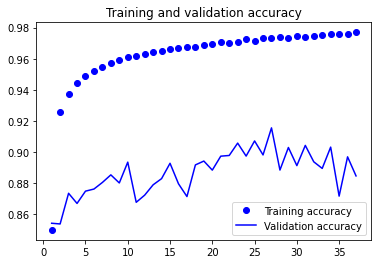

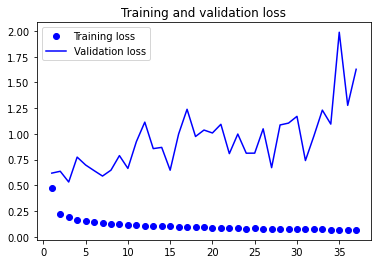

In [156]:
#결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

#단순한 특성 추출 방식의 훈련 정확도와 검증 정확도 그래프 그리기
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#단순한 특성 추출 방식의 훈련 손실과 검증 손실 그래프 그리기
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# **4. 모델 저장**

In [157]:
model = resnet18

In [158]:
save_path = '/content/'
team_name = 'team04'

# 트레이닝된 전체 모델을 저장합니다.
model.save(save_path +  'model_entire_'+ team_name + '.h5')

# **5. 모델 로드 및 평가**

In [159]:
save_path = '/content/'
team_name = 'team04'

model = keras.models.load_model(save_path + 'model_entire_' + team_name + '.h5')

model.evaluate(x_test_after, y_test)

1250/1250 [==============================] - 9s 7ms/step - loss: 1.6283 - accuracy: 0.8846


[1.6282691955566406, 0.8846250176429749]